Creator: Ryan Corbyn
Date created: 12/10/2020

Edited:     Name         Date      Reason

Ryan Corbyn  13/10/2020

Ryan Corbyn  30/10/2020 - Correct the 11 point selection process so that it is based on fluorescence intenstiy and not frequency position. 

This is a program that is designed to load in data from a full CW ODMR measurement. 

From here, the line scans are averaged to give the mean ODMR spectra, this is then plotted as a scatter graph and a double lorentzian line shape is fitted to the data. 

The fitting parameters are saved to a data file, along with the plot. 

Finally, the Double lorentzian lineshape fitting is used to generate an 11 point frequnecy sweep that can be used for both temeprature sensing and magentic field sensing. 

In [1]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd

In [2]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    
    return(data_array)

In [3]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [4]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

In [5]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [6]:
def plot_heat_map(freq, odmr_data, dwell_time):
    # plot the full ODMR data as a heatmap. 
    number_of_scans = len(odmr_data)
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    fig1, ax1 = plot.subplots()
    
    hm = ax1.pcolormesh(freq, Y, odmr_data, cmap = 'viridis')
    fig1.colorbar(hm, label = '\ncounts per ' + str(dwell_time) + r' $\mu$s')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of scans')
    
    return(fig1, ax1)

In [7]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data =  np.mean(odmr_data, axis=0)
    return(mean_odmr_data)

In [8]:
def normalise_data(mean_odmr_data):
    # normalise the data to the maximum value of the mean dataset. 
    norm_odmr_data = mean_odmr_data/(np.max(mean_odmr_data))
    return(norm_odmr_data)

In [9]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [10]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    half_data_length = int((len(freq)-1)/2)
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate contrast for ODMR peaks
    contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
                np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, contrast, flourescent_baseline)

In [11]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [12]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [13]:
def plot_fitting(ax2, freq, y_fit):
    # plot the y fit. 
    
    ax2.plot(freq, y_fit, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    ax2.set_xlabel('Microwave Frequency (GHz)')
    ax2.set_ylabel('Normalised Counts')
    
    return(ax2)
 

In [14]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [15]:
def save_data(date, file_ID, contrast, coeffs, opt_error, r_squared, fig1, fig2):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\Thermometry\\' + date + '\\'
    output_data_file = destination_folder + date + '_NVScan_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  ', \t' + 
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'Resonant frequency 1 contrast (%)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'Resonant frequency2 contrast (%)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per dwell time)' + '\t' +'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID + ' \t' +  
                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
                 str(contrast[0]*100) + " \t"  +  
                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(contrast[1]*100) + " \t" +
                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[6]) + " \t" +str(r_squared) + '\n')
        
    # Saving a plot of the raw data to a folder. 
    fig1.savefig(destination_folder + file_ID + '_heatmap.pdf', transparent = True)    
    fig1.savefig(destination_folder + file_ID + '_heatmap.png', transparent = True) 
    
    fig2.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    fig2.savefig(destination_folder + file_ID + '.png', transparent = True) 
    

<ipython-input-6-361831fa10c0>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hm = ax1.pcolormesh(freq, Y, odmr_data, cmap = 'viridis')


0.9135441764927595
[0.1154271225748833, 0.05954818593613653]
[2.865, 2.875]


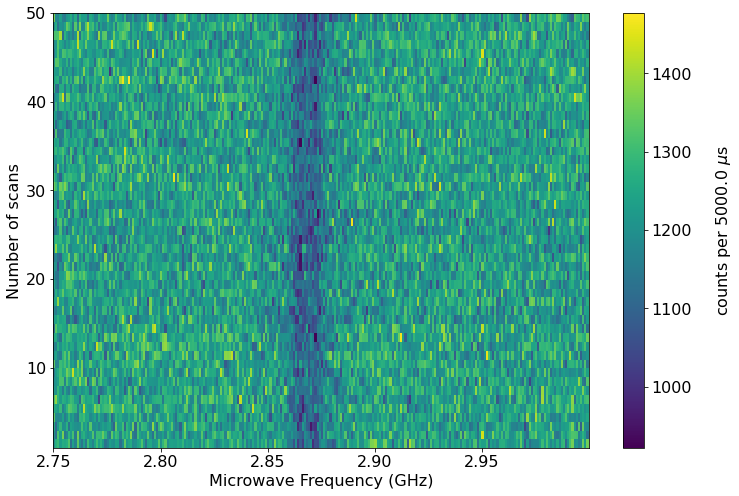

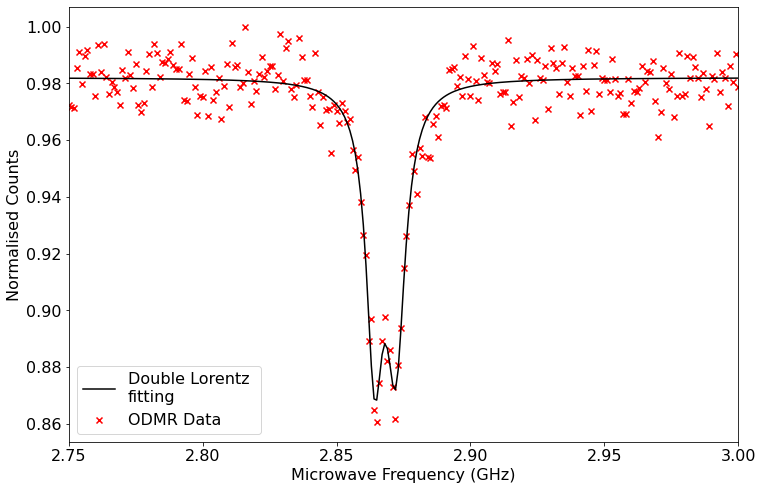

In [16]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and Imaging\\'
date = '20210217'
file_name = date + '_NVScan_22'

odmr_data = load_data(folder_path + date + '\\' + file_name + '.dat')
params_file = load_params(folder_path + date + '\\' + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# plot a colour map of the ODMR data and set plot format for the program. 
set_plot_params()
fig1, ax1 = plot_heat_map(freq, odmr_data, params_values[3])

# find the mean of the ODMR data
mean_odmr_data = mean_data(odmr_data)
# Normalise the dataset
norm_mean_odmr = normalise_data(mean_odmr_data)

# scatter plot of data
fig2, ax2 = scatter_plot(freq, norm_mean_odmr)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, contrast, flourescent_baseline = get_init_params(norm_mean_odmr, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
#init_params = [contrast[0], freq_mins[0], 0.001, contrast[1], freq_mins[1], 0.001, flourescent_baseline]
init_params = [contrast[0], 2.865, 0.001, contrast[1], 2.87, 0.001, flourescent_baseline]

lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, norm_mean_odmr, 
                                                     init_params, lower_bounds, upper_bounds)

# create the double lorentz fit array
y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])

# plot the fitting to ax2
ax2 = plot_fitting(ax2, freq, y_fit)

# Find the FWHM for the curve fitting. 
#fwhm = get_FWHM(freq, y_fit, freq_mins, fitting_params[6], params_values[2])
    
# get the r^2 value for the fitting 
r_squared = get_r_squared(freq, norm_mean_odmr, y_fit)
print(r_squared)
print(contrast)
print(freq_mins)
#save_data(date, file_name, contrast, fitting_params, error_in_fit, r_squared, fig1, fig2)

Here we start the code to determine where the 6 points are in frequency space that will be used for the faster ODMR. 

We start by splitting the frequnecy array up into two parts from the two minima. 

In [102]:
def split_freq_array(freq, freq_mins):
    '''Here we start by splitting the frequnecy array to 2 parts from the two minima.'''
    
    freq_min_index = []
    
    freq_min_index.append( int(np.where( freq == round(np.min(freq_mins), 3))[0] ))
    freq_min_index.append( int(np.where( freq == round(np.max(freq_mins), 3) )[0] ))
    
    return(freq_min_index)
    

In [103]:
def find_straight_lines(off_res_sig, y_fit, sorted_array_index):
    
    # Find the upper and lower limits for the straight line portion of the graph.
    upper_limit = 0.97*off_res_sig
    lower_limits = [1.01*y_fit[sorted_array_index[0][-1]],
                   1.01*y_fit[sorted_array_index[1][0]]]
    
    lower_limit = np.min(lower_limits)
    
    # Create a variable to store the indicies corresponding to the values which 
    # lie within the straight line part of the graph. 
    storage = []
    straight_line_index = []
    
    # Two loops used to find the negative and positive slopes of the graph. 
       
    for j in range(len(sorted_array_index[0]-1)): 
        if y_fit[sorted_array_index[0][j]] >= lower_limit and y_fit[sorted_array_index[0][j]] <= upper_limit:
            storage.append(j)
                
    straight_line_index.append(storage)
    storage = []
    
    for j in range(len(sorted_array_index[1]-1)):
        if y_fit[sorted_array_index[1][j]] >= lower_limit and y_fit[sorted_array_index[1][j]] <= upper_limit:
            storage.append(j + sorted_array_index[1][0])
            
    straight_line_index.append(storage)
        
    
    return(straight_line_index)

In [104]:
def straight_line(x, m, c):
    '''A stright line equation'''
    y = m*x + c
    return(y)

In [105]:
def get_fitted_linear(freq, y_fit, linear_index):
    '''Creates a high resolution (~kHz) frequency array and uses 
    this to generate straight line fits for the linear portion of the 
    ODMR lorentz fitting.'''
    
    # Create High resolution straight_lines
    low_freq_high_res = np.linspace(freq[linear_index[0][0]], freq[linear_index[0][-1]], 10001)
    high_freq_high_res = np.linspace(freq[linear_index[1][0]], freq[linear_index[1][-1]], 10001)
    # inital fit parameters
    p0 = [0, 0]
    
    # Find the fitting parameters for the straight lines. 
    y_lower_coeffs, conf_low = opt.curve_fit(straight_line, freq[linear_index[0]],  y_fit[linear_index[0]], p0) 
    low_error = np.sqrt(np.diag(conf_low))
    y_higher_coeffs, conf_high = opt.curve_fit(straight_line, freq[linear_index[1]],  y_fit[linear_index[1]], p0) 
    high_error = np.sqrt(np.diag(conf_high))
                  
    return(y_lower_coeffs, low_error, low_freq_high_res, y_higher_coeffs, high_freq_high_res, high_error, y_fit_high)
                                     

In [106]:
def find_6_freq_points(freq, low_freq_high_res, y_fit_low, high_freq_high_res, y_fit_high):
    '''This part of the code finds the 6 frequncy points that are 
    needed for the 6 point ODMR. 
    0. The first 2 frequnecy points are the start and end frequnecy values used in the original ODMR scan. 
    1. We find the mid-point of the low frequnecy straight line (f-). 
    2. We find the mid -points then between f- and the beginning and end of the straight line array (+delta_f-, -delta_f-)
    3. These frequnecies +delta_f-, -delta_f- are the second set of frequency points, and deltaf needs to be saved.
    4. Find the point on the high frequncey straight line that has the same value as f-
    5. find the final two frequncy points (+delta_f+, -delta_f+)'''
    
    # Create the frequency array.
    freq_array = []
    # Populate the frequency array with the first frequency value.  
    freq_array.append(freq[0])
    
    # Find the index mid-point of the stright line fitting. 
    mid_index = int(len(low_freq_high_res)/2)
    # Find the data point quarter of the way through the array. 
    delta_f_index = int(len(low_freq_high_res)/4)
    
    # Select the 2 frequnecy points on the low freqeuncy straight line. 
    freq_array.append(round(low_freq_high_res[delta_f_index],9))
    freq_array.append(round(low_freq_high_res[mid_index+delta_f_index],9))    
    
    # Find the index at which the high frequnecy straight line curve has the same value 
    # as the mid-point of the low frequnecy straight line. 
    mid_y_value = np.abs(y_fit_high - y_fit_low[mid_index]).argmin()
    
    # Select the 2 frequnecy points on the high freqeuncy straight line.
    freq_array.append(round(high_freq_high_res[mid_y_value - delta_f_index],9))
    freq_array.append(round(high_freq_high_res[mid_y_value + delta_f_index],9))
    
    # Select the last value from the original ODMR frequency array. 
    freq_array.append(freq[-1])
    
    delta_freq = round((low_freq_high_res[mid_index+delta_f_index] - low_freq_high_res[delta_f_index])/2,9)
    
    return(freq_array, delta_freq, [delta_f_index, mid_index+delta_f_index, mid_y_value])
    

In [130]:
def save_6_point_fitting_data(date, file_ID, linear_fit_params, linear_fit_error, fig):
    
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\' + date + '\\'
    output_data_file = destination_folder + '6_point_thermometry_fitting ' + file_ID +  '.dat'
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    if not os.path.exists(output_data_file):
        with open(output_data_file, "w") as wf:
            wf.write('6 point thermometry initial data' + '\n' + 
                     'linear fit number' + '\t' + 'Gradient (counts per GHz)' + '\t' + 'Error in Gradient (counts per GHz)' + '\t' +
                     'Intercept (counts)' + '\t' + 'Error in Intercept (counts per GHz)' + '\t' + '\n') 
            
    for i in range(len(linear_fit_error)):
        with open(output_data_file, "a") as wf:
            wf.write('Linear fit ' + str(i+1) + '\t' + 
                        str(linear_fit_params[i][0])  + '\t' + str(linear_fit_error[i][0])  + '\t' +
                        str(linear_fit_params[i][1])  + '\t' + str(linear_fit_error[i][1])  + '\t' + '\n')
            
        
    fig.savefig(destination_folder + '6 point ODMR fitting ' + file_ID  + '.pdf', transparent = True)
    fig.savefig(destination_folder + '6 point ODMR fitting ' + file_ID  + '.png', transparent = True)

In [123]:
def create_generator_list(folder_path, ODMR_freqs, date, file_name):
    '''Creates a text file containing the 11 frequnecies in Hz that 
    can be transferred to the microwave generator.'''
        
    frequency = []
    
    # Create an array with all of the 6 ODMR frequnecies chosen for the fast ODMR 
    # each frequnecy is repeated 11 times. The first iteration of each value is 
    # to allow the microwave generator to adjust to the new frequency and then 
    # the 10 following values will be used for the ODMR measurment. 
    for i in range(len(ODMR_freqs)):
        for j in range(11):
            frequency.append(np.array(ODMR_freqs[i])*np.power(10,9))


    save_path = folder_path + date + '\\' + date + file_name + '_6_ODMR_points_' + '.txt'
    
    for i in range(len(frequency)):
        with open(save_path, "a") as wf:
            wf.write(str(int(frequency[i])) + '\t' + '12.0' + '\n')

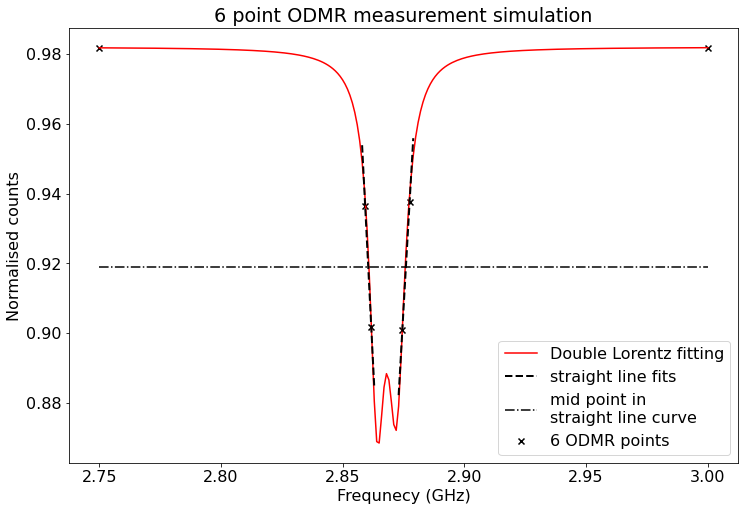

In [116]:
# Plot the lorentz fitting for the ODMR curve. 
fig, ax3 = plot.subplots()
ax3.plot(freq, y_fit, color = 'r', label = 'Double Lorentz fitting')
ax3.set_xlabel('Frequnecy (GHz)')
ax3.set_ylabel('Normalised counts')
ax3.set_title('6 point ODMR measurement simulation')

# Find the index in the ODMR curve corresponding to the ODMR minimas. 
split_index_array = split_freq_array(freq, [fitting_params[1], fitting_params[4]])

# Generate two index arrays. 
# From beginning to first minima, and  from second minima to end. 
first_freq_index_array = np.linspace(0, split_index_array[0], split_index_array[0]+1, dtype = int)
second_freq_index_array = np.linspace(split_index_array[1], len(freq)-1, len(freq) - split_index_array[1], dtype = int)

# Find the linear portions of the ODMR curves. 
linear_index = find_straight_lines(fitting_params[6], y_fit, 
                    [first_freq_index_array, second_freq_index_array])

# Generate the straight line fittings for the linear portion of the ODMR curves. 
y_lower_coeffs, low_error, low_freq_high_res, y_higher_coeffs, high_freq_high_res, high_error, y_fit_high = get_fitted_linear(freq, y_fit, linear_index)

# Create the straight line fittings. 
y_fit_low = straight_line(low_freq_high_res, y_lower_coeffs[0], y_lower_coeffs[1])
y_fit_high = straight_line(high_freq_high_res, y_higher_coeffs[0], y_higher_coeffs[1])

# Plot the linear fittings. 
ax3.plot(low_freq_high_res, y_fit_low, color = 'k', 
        label = 'straight line fits', linestyle = '--', 
         linewidth = 2)
ax3.plot(high_freq_high_res, y_fit_high, color = 'k', 
         linestyle = '--', linewidth = 2)

# Get the 6 frequnecy points for the fast 6 point ODMR curve. 
six_point_frequnecies, delta_f, indicies = find_6_freq_points(freq, low_freq_high_res, y_fit_low, high_freq_high_res, y_fit_high)

# Extract the y values for the 6 ODMR frequnecy points.
y_values = [y_fit[0], y_fit_low[indicies[0]], y_fit_low[indicies[1]],
           y_fit_high[indicies[2] - indicies[0]], y_fit_high[indicies[2] + indicies[0]], 
            y_fit[-1]]

# Plot the 6 ODMR frequnecy points and a dotted line 
ax3.scatter(six_point_frequnecies, y_values, marker = 'x', color = 'k', 
           label = '6 ODMR points')
ax3.plot([freq[0], freq[-1]], [y_fit_low[indicies[2]], y_fit_low[indicies[2]]], 
        linestyle = '-.', color = 'k', label='mid point in \nstraight line curve')

ax3.legend(loc='lower right')

Save all the fitting parameters and generate the list that will be used for faster ODMR. 

In [128]:
#save_6_point_fitting_data(date, file_name, [y_lower_coeffs, y_higher_coeffs], [low_error, high_error], fig)
#create_generator_list(folder_path, six_point_frequnecies, date, file_name)

0.9135441764927595
